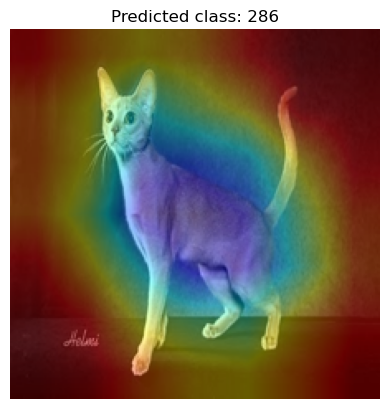

In [3]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Preprocessing function
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]    # ImageNet std
        )
    ])
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, input_tensor

# Function to register a forward hook and capture feature maps
def get_feature_hook(layer_outputs):
    def hook(module, input, output):
        layer_outputs.append(output.detach())
    return hook

# Function to compute CAM
def compute_cam(features, weights, class_idx):
    features = features.squeeze(0)  # Shape: [C, H, W]
    cam = torch.zeros(features.shape[1:], dtype=torch.float32)
    for i in range(features.shape[0]):
        cam += weights[class_idx, i] * features[i, :, :]
    cam = cam.numpy()
    cam = np.maximum(cam, 0)
    cam /= cam.max()
    return cam

# Function to overlay CAM on original image
def show_cam_on_image(original_img, cam, title="CAM"):
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(original_img.resize((224, 224)))
    overlay = heatmap * 0.4 + img_np * 0.6
    plt.imshow(overlay.astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main CAM function
def cam_visualization(img_path):
    # Load model
    model = models.resnet18(pretrained=True)
    model.eval()

    # Register hook to get final conv layer output
    layer_outputs = []
    hook = model.layer4.register_forward_hook(get_feature_hook(layer_outputs))

    # Preprocess and predict
    original_img, input_tensor = preprocess_image(img_path)
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

    # Get classifier weights
    fc_weights = model.fc.weight.detach()

    # Compute CAM
    features = layer_outputs[0]  # From hook
    cam = compute_cam(features, fc_weights, class_idx)

    # Show
    show_cam_on_image(original_img, cam, title=f"Predicted class: {class_idx}")

    # Clean up
    hook.remove()

# Example usage
cam_visualization("cat2.jpg")  # Replace with your image path


In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Load model
model = models.resnet18(pretrained=True).eval()

# Register hook to capture features from a specific layer
features = []
def hook_fn(module, input, output):
    features.append(output.detach())

# You can change to 'layer1', 'layer2', etc.
hook = model.layer3.register_forward_hook(hook_fn)

# Image preprocessing
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0)
    return img, input_tensor

# Save feature maps as images
def save_feature_maps(features, save_dir="feature_maps", prefix="layer3"):
    os.makedirs(save_dir, exist_ok=True)
    fmap = features.squeeze(0)  # [C, H, W]

    for i in range(fmap.shape[0]):
        fmap_np = fmap[i].cpu().numpy()
        fmap_np -= fmap_np.min()
        fmap_np /= fmap_np.max() + 1e-5
        fmap_np = np.uint8(255 * fmap_np)

        # Optionally convert to color map
        colored_map = cv2.applyColorMap(fmap_np, cv2.COLORMAP_JET)

        filename = os.path.join(save_dir, f"{prefix}_channel_{i:03d}.jpg")
        cv2.imwrite(filename, colored_map)

# Example usage
img_path = "cat1.jpg"  # Replace with your image
_, input_tensor = preprocess_image(img_path)
with torch.no_grad():
    _ = model(input_tensor)

save_feature_maps(features[0], save_dir="layer3_maps", prefix="layer3")

hook.remove()


## GRAD CAM

/home/marcos/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


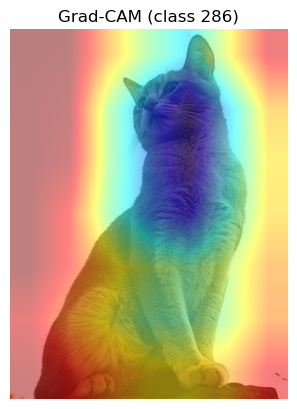

In [8]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# Preprocessing
# -----------------------------
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0)
    return img, tensor

# -----------------------------
# Grad-CAM core class
# -----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero grads and backprop
        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        # Get gradients and activations
        gradients = self.gradients  # [B, C, H, W]
        activations = self.activations  # [B, C, H, W]

        pooled_grads = torch.mean(gradients, dim=(2, 3))  # [B, C]
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32)

        for i in range(activations.shape[1]):
            cam += pooled_grads[0, i] * activations[0, i]

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam.cpu().numpy(), class_idx

# -----------------------------
# Visualize CAM
# -----------------------------
def overlay_cam(img, cam, alpha=0.5):
    cam = cv2.resize(cam, (img.width, img.height))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(img)
    overlay = heatmap * alpha + img_np * (1 - alpha)
    return overlay.astype(np.uint8)

# -----------------------------
# Example usage
# -----------------------------
def grad_cam_demo(img_path):
    model = models.resnet18(pretrained=True)
    target_layer = model.layer4[1].conv2  # or model.layer4[-1] for more general cases

    img, input_tensor = preprocess_image(img_path)
    grad_cam = GradCAM(model, target_layer)
    cam, class_idx = grad_cam.generate(input_tensor)

    overlay = overlay_cam(img, cam)

    # Show or save result
    plt.imshow(overlay)
    plt.title(f"Grad-CAM (class {class_idx})")
    plt.axis('off')
    plt.show()

# Call with your image path
grad_cam_demo("cat1.jpg")


 What's Happening
Forward hook captures activations from target_layer.

Backward hook captures gradients w.r.t. those activations.

Grad-CAM formula uses global-average-pooled gradients to weigh channels of the activation map.

Result is resized and overlaid on the input image.

🔧 You can:
Change target_layer to other convolutional layers.

Specify a class_idx manually if you want to force Grad-CAM for a specific class.

Save the result instead of plotting with cv2.imwrite.

maybe compate latter with vgg o resnet50

In [9]:
from torchvision import models
from torchsummary import summary


summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [10]:
def print_named_modules(model):
    for name, module in model.named_modules():
        print(name, '->', type(module))

model = models.resnet50(pretrained=True)
print_named_modules(model)


/home/marcos/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/marcos/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.7MB/s]


 -> <class 'torchvision.models.resnet.ResNet'>
conv1 -> <class 'torch.nn.modules.conv.Conv2d'>
bn1 -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu -> <class 'torch.nn.modules.activation.ReLU'>
maxpool -> <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1 -> <class 'torch.nn.modules.container.Sequential'>
layer1.0 -> <class 'torchvision.models.resnet.Bottleneck'>
layer1.0.conv1 -> <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv2 -> <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv3 -> <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn3 -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.relu -> <class 'torch.nn.modules.activation.ReLU'>
layer1.0.downsample -> <class 'torch.nn.modules.container.Sequential'>
layer1.0.downsample.0 -> <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.downsample.1 -> <class 'torch.nn.modules.batchnorm.Batc

In [11]:
# show only top level modules

from torchvision import models

model = models.resnet50(pretrained=True)

for name, module in model.named_children():
    print(name, '->', module.__class__.__name__)


conv1 -> Conv2d
bn1 -> BatchNorm2d
relu -> ReLU
maxpool -> MaxPool2d
layer1 -> Sequential
layer2 -> Sequential
layer3 -> Sequential
layer4 -> Sequential
avgpool -> AdaptiveAvgPool2d
fc -> Linear


In [12]:
# one level deeper
for i, block in enumerate(model.layer4):
    print(f'layer4[{i}] -> {block.__class__.__name__}')


layer4[0] -> Bottleneck
layer4[1] -> Bottleneck
layer4[2] -> Bottleneck


## Saliency MAP

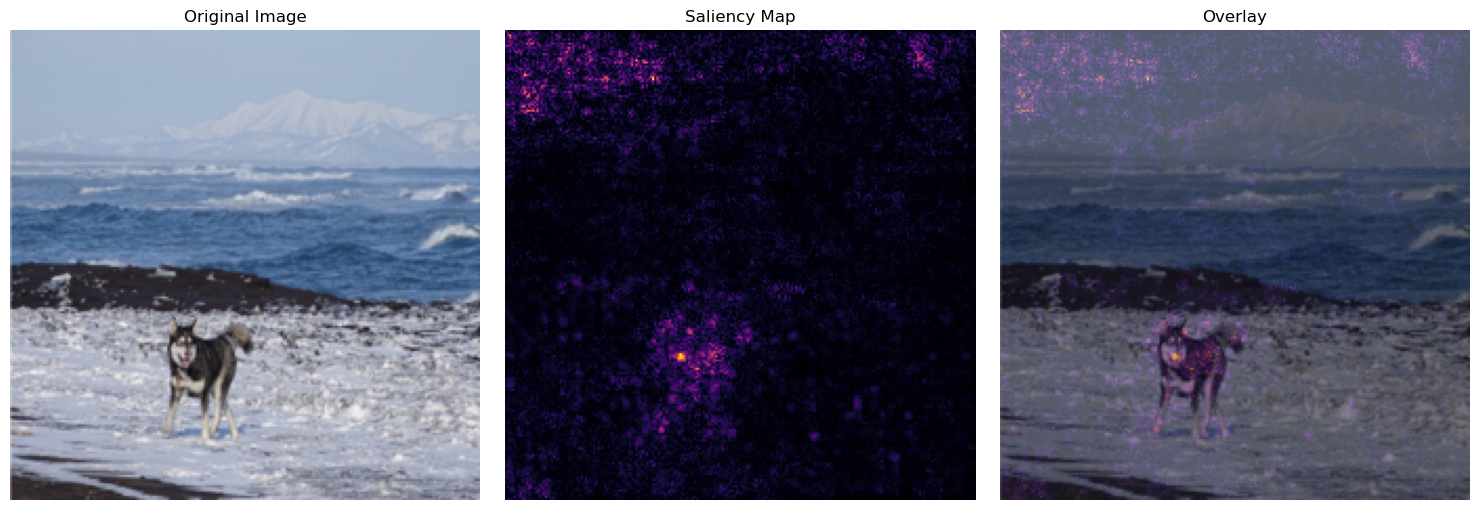

In [20]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Preprocess the input image
# -----------------------------
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    tensor = transform(img).unsqueeze(0)
    return img, tensor.requires_grad_()

# -----------------------------
# Saliency computation
# -----------------------------
def compute_saliency(model, input_tensor, class_idx=None):
    model.eval()
    input_tensor.requires_grad_()
    
    output = model(input_tensor)

    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    score = output[0, class_idx]
    model.zero_grad()
    score.backward()

    saliency = input_tensor.grad.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)  # take max over channels
    saliency -= saliency.min()
    saliency /= saliency.max() + 1e-8

    return saliency.numpy(), class_idx

# -----------------------------
# Overlay creation
# -----------------------------
def create_overlay(original_img, saliency_map, alpha=0.5, cmap='inferno'):
    saliency_colored = plt.get_cmap(cmap)(saliency_map)
    saliency_img = Image.fromarray((saliency_colored[:, :, :3] * 255).astype(np.uint8)).resize(original_img.size)
    overlay = Image.blend(original_img, saliency_img, alpha=alpha)
    return overlay

# -----------------------------
# Display
# -----------------------------
def show_saliency(original_img, saliency_map, cmap="inferno"):
    overlay_img = create_overlay(original_img, saliency_map, cmap=cmap)
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap=cmap)
    plt.title("Saliency Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_img)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Run example
# -----------------------------
def saliency_demo(img_path):
    model = models.resnet50(pretrained=True)
    img, input_tensor = preprocess_image(img_path)
    saliency_map, class_idx = compute_saliency(model, input_tensor)
    show_saliency(img, saliency_map)

# Example usage
saliency_demo("wolf.png")


Saliency maps show which pixels in the input image most affect the predicted class, using the gradient of the output w.r.t. the input image.

In [22]:

# Load model
model = models.resnet50(pretrained=True).eval()


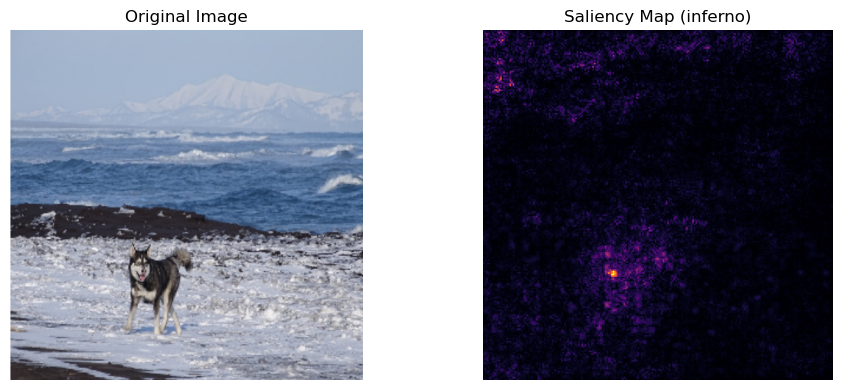

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Preprocess the input image
# -----------------------------
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0)
    return img, tensor.requires_grad_()

# -----------------------------
# Saliency computation
# -----------------------------
def compute_saliency(model, input_tensor, class_idx=None):
    model.eval()
    input_tensor.requires_grad_()
    
    output = model(input_tensor)

    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    score = output[0, class_idx]
    model.zero_grad()
    score.backward()

    saliency = input_tensor.grad.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)  # take max over channels
    saliency -= saliency.min()
    saliency /= saliency.max() + 1e-8

    return saliency.numpy(), class_idx

# -----------------------------
# Display
# -----------------------------
def show_saliencyv0(original_img, saliency_map):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



def show_saliency(original_img, saliency_map, cmap="inferno"):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    #plt.imshow(saliency_map, cmap=cmap)
    plt.imshow(saliency_map, cmap='inferno')  # ← was 'hot'
    plt.title(f"Saliency Map ({cmap})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# -----------------------------
# Run example
# -----------------------------
def saliency_demo(img_path):
    model = models.resnet50(pretrained=True)
    img, input_tensor = preprocess_image(img_path)
    saliency_map, class_idx = compute_saliency(model, input_tensor)
    show_saliency(img, saliency_map)

# Example usage
saliency_demo("wolf.png")


This uses input_tensor.grad after calling backward() on the score of the predicted class.

torch.max(..., dim=0) combines RGB channels into one map using the most "influential" gradient.

saliency_map is normalized to [0, 1] and plotted as a heatmap.

In [5]:
import torch
import matplotlib.pyplot as plt

def show_saliency_map(model, image_tensor, label=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    image_tensor.requires_grad_()  # Enable gradient tracking

    output = model(image_tensor)
    score = output.squeeze()  # Scalar prediction

    model.zero_grad()
    score.backward()  # Backprop to get gradients w.r.t. input image

    saliency = image_tensor.grad.data.abs().squeeze()  # Take absolute value of gradients

    # Take maximum across color channels
    saliency, _ = torch.max(saliency, dim=0)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency.cpu(), cmap='hot')
    plt.title("Saliency Map")

    if label is not None:
        print(f"True label: {'Dog' if label == 1 else 'Cat'} - Prediction: {output.item():.4f}")

    plt.tight_layout()
    plt.show()


In [6]:
from PIL import Image
from torchvision import transforms

image_path = "cat.png"

# Define the transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # resize to model input size
    transforms.ToTensor(),           # convert to tensor [0,1]
    transforms.Normalize(            # normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])
])

# Load image with PIL
img = Image.open(image_path).convert("RGB")

# Apply transform
#img_tensor = transform(img)  # tensor shape: [3, 224, 224]

# Add batch dimension if needed (for model input)
#img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 3, 224, 224]


In [7]:
#image, label = train_dataset[0]  # change index if needed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#image = "Cat3.png"
img_tensor = img_tensor.to(device)

show_saliency_map(model, img_tensor)

NameError: name 'img_tensor' is not defined

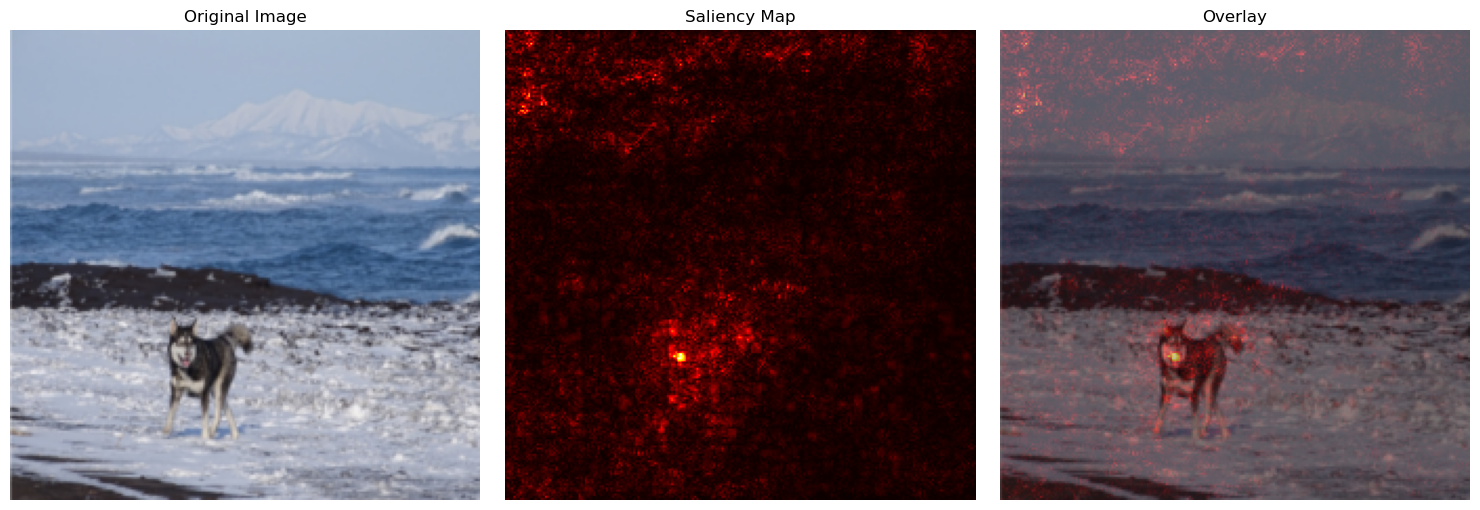

In [12]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Saliency map function
def show_saliency_map(model, image_tensor, label=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad_()

    output = model(image_tensor)

    # Option 1: Predicted class
    predicted_class = output.argmax(dim=1)
    score = output[0, predicted_class]

    # OR Option 2: Specific class (e.g., 243 = "bull mastiff")
    # class_idx = 243
    # score = output[0, class_idx]

    model.zero_grad()
    score.backward()

    saliency = image_tensor.grad.data.abs().squeeze()
    saliency, _ = torch.max(saliency, dim=0)

    # Unnormalize image for display
    img_display = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = img_display.clip(0, 1)

    saliency_np = saliency.cpu().numpy()

    # Plot
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")

    # Saliency map
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_np, cmap='hot')
    plt.title("Saliency Map")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_display)
    plt.imshow(saliency_np, cmap='hot', alpha=0.5)
    plt.title("Overlay")
    plt.axis("off")

    if label is not None:
        print(f"True label: {'Dog' if label == 1 else 'Cat'} - Prediction: {output.item():.4f}")

    plt.tight_layout()
    plt.show()

# Load and preprocess image
image_path = "wolf.png"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_tensor = transform(img)

# Load model
model = models.resnet50(pretrained=True).to(device)

# Show saliency map
show_saliency_map(model, img_tensor)


In [14]:
import urllib.request

# Download the image
image_url = "https://upload.wikimedia.org/wikipedia/commons/d/d7/White_stork_%28Ciconia_ciconia%29_on_nest.jpg"
image_path = "stork.jpg"
urllib.request.urlretrieve(image_url, image_path)


('stork.jpg', <http.client.HTTPMessage at 0x739bd3d3ba90>)

In [18]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2025-06-03 16:03:40--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolviendo cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Conectando con cdn.pixabay.com (cdn.pixabay.com)[104.18.40.96]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 215472 (210K) [image/jpeg]
Guardando como: ‘image.jpg’

image.jpg           100%[===================>] 210,42K  --.-KB/s    en 0,03s   

2025-06-03 16:03:40 (7,43 MB/s) - ‘image.jpg’ guardado [215472/215472]

